# Extract Data

In [13]:
import requests
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [16]:
stock_prices = pd.read_csv("/Users/nichollastidow/Downloads/stock_prices.csv")

In [17]:
stock_prices.head()

,timestamp,T,VZ
0,2019-01-02,29.54,56.02
1,2019-01-03,29.58,56.22
2,2019-01-04,30.34,56.36
3,2019-01-07,30.89,56.72
4,2019-01-08,31.28,58.38


In [36]:
stock_prices['timestamp'] = pd.to_datetime(stock_prices['timestamp'])

In [37]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  505 non-null    datetime64[ns]
 1   T          505 non-null    float64       
 2   VZ         505 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 12.0 KB


In [41]:
stock_prices.set_index('timestamp')

,T,VZ
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38
...,...,...
2020-12-24,28.69,58.84
2020-12-28,28.55,58.98
2020-12-29,28.54,58.81


In [43]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  505 non-null    datetime64[ns]
 1   T          505 non-null    float64       
 2   VZ         505 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 12.0 KB


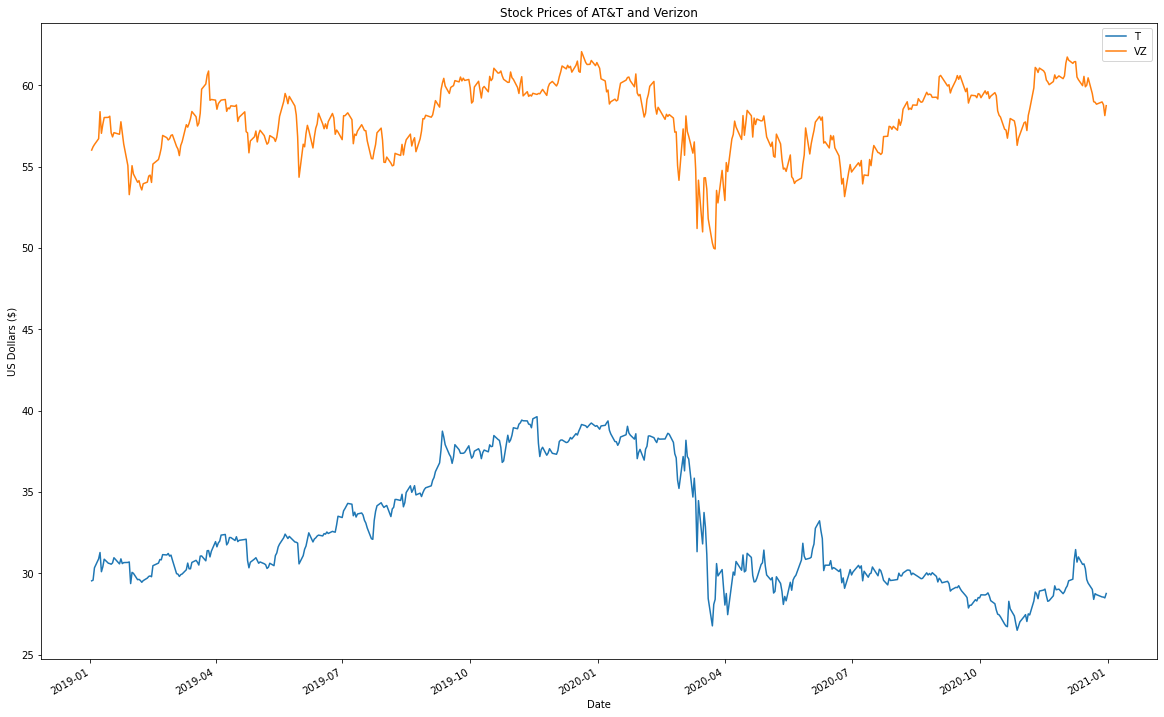

In [79]:
#stock_prices.plot()
plt.rcParams['figure.figsize'] = [20,13]
stock_prices.plot(y=['T','VZ'], x ='timestamp')
plt.title("Stock Prices of AT&T and Verizon")
plt.ylabel('US Dollars ($)')
plt.xlabel('Date')
plt.show()

In [ ]:
# Both seem to drop around early 2020. Explained by COVID-19 outbreak and sell off. Verizon more positive trend since.

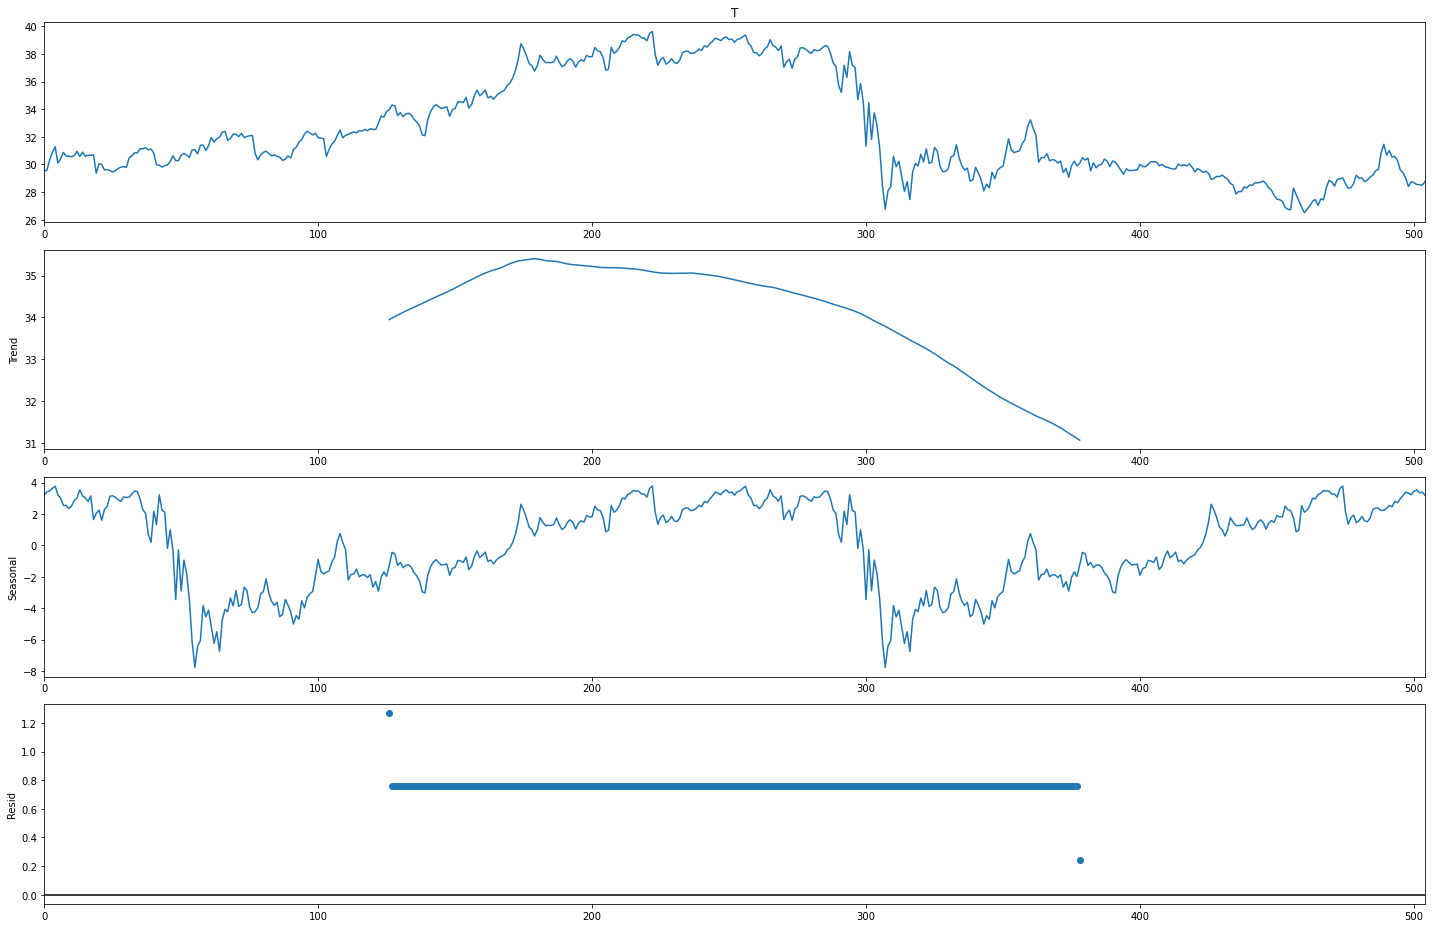

In [80]:
seasonal_decompose(stock_prices['T'],
                  model='additive',
                  period = int(len(stock_prices)/2)).plot();

In [51]:
# 1st plot is raw data, 2nd trend, 3rd seasonality,4th residuals

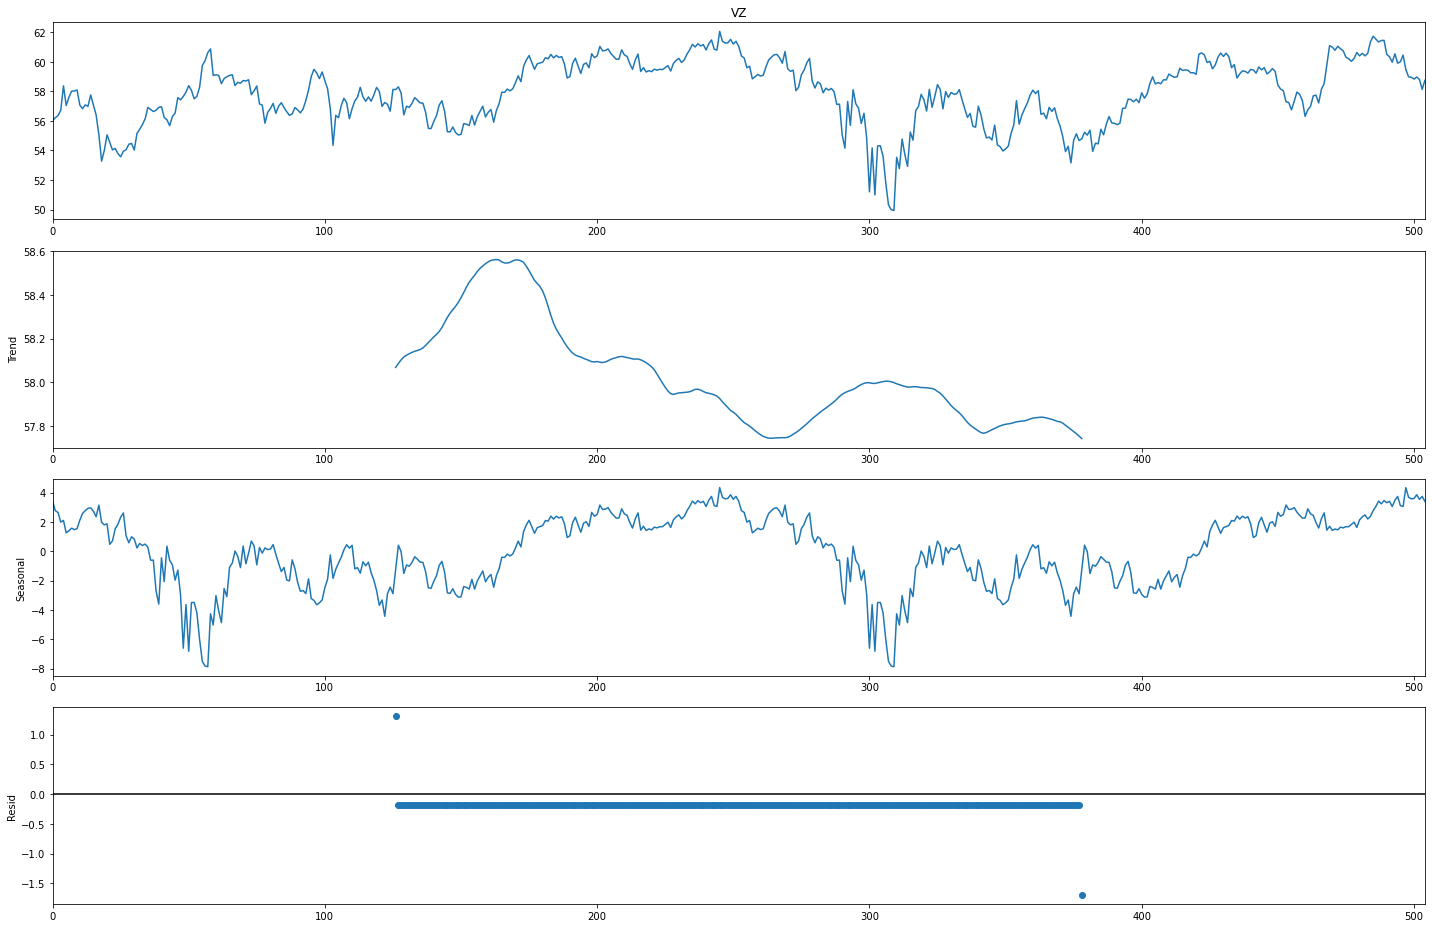

In [81]:
seasonal_decompose(stock_prices['VZ'],
                  model='additive',
                  period = int(len(stock_prices)/2)).plot();

# Identifying Time Series Components
#### A time series analysis can isolate each component and quantify the extent to which each component influences the form of the observed data. - David Gerbing

Use ACF and PACF (Autocorrelation and Partial Autocorrelation) plots to choose optimal number of lags of independent variables.

These plots will also help understand if the data is stationary

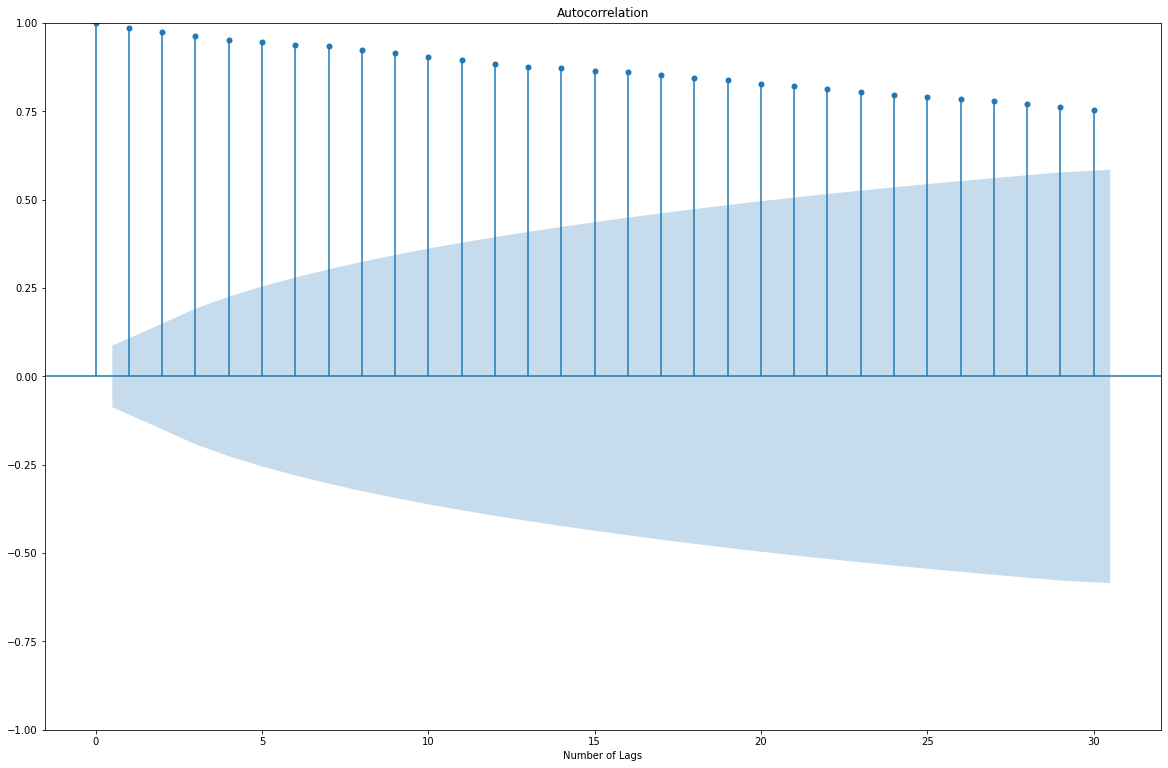

In [82]:
# AT&T ACF 
afc_T = sm.graphics.tsa.plot_acf(stock_prices['T'], lags = 30)
plt.xlabel('Number of Lags')
plt.show()

The correlations for AT&T decrease slowly. Based on this decreases, we are likely dealing with an autoregressive process.

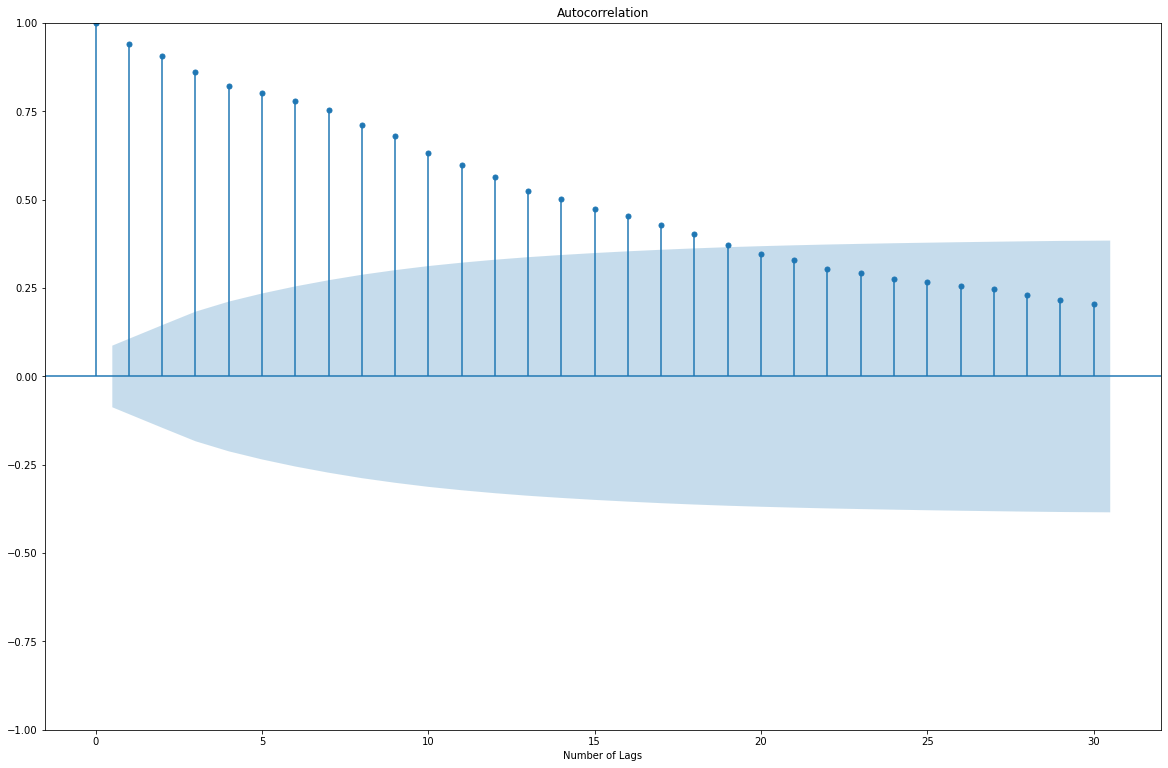

In [87]:
# V ACF 
afc_V = sm.graphics.tsa.plot_acf(stock_prices['VZ'], lags = 30)
plt.xlabel('Number of Lags')
plt.show()

18 significant terms

ACF is the correlation between the time series data and a lagged version of itself. Basically, describes how well the present value is related to past values. The cone represents a 95% confidence interval by default. This means that data outside this cone are likely correlated.

Some questions that can be answered with ACF plot are:
    1) Is the TS white noise/random?
    2) Can the TS be modeled with a Moving Average model?
        If so, what is the order?
        


PACF find the correlation of the residuals with the next lag value. 
If correlation values outside the confidence interval, then its a good predictor and could be added to the model. 
PACF can answer the following question: Can the TS be modeled with an Auto Regressive model?

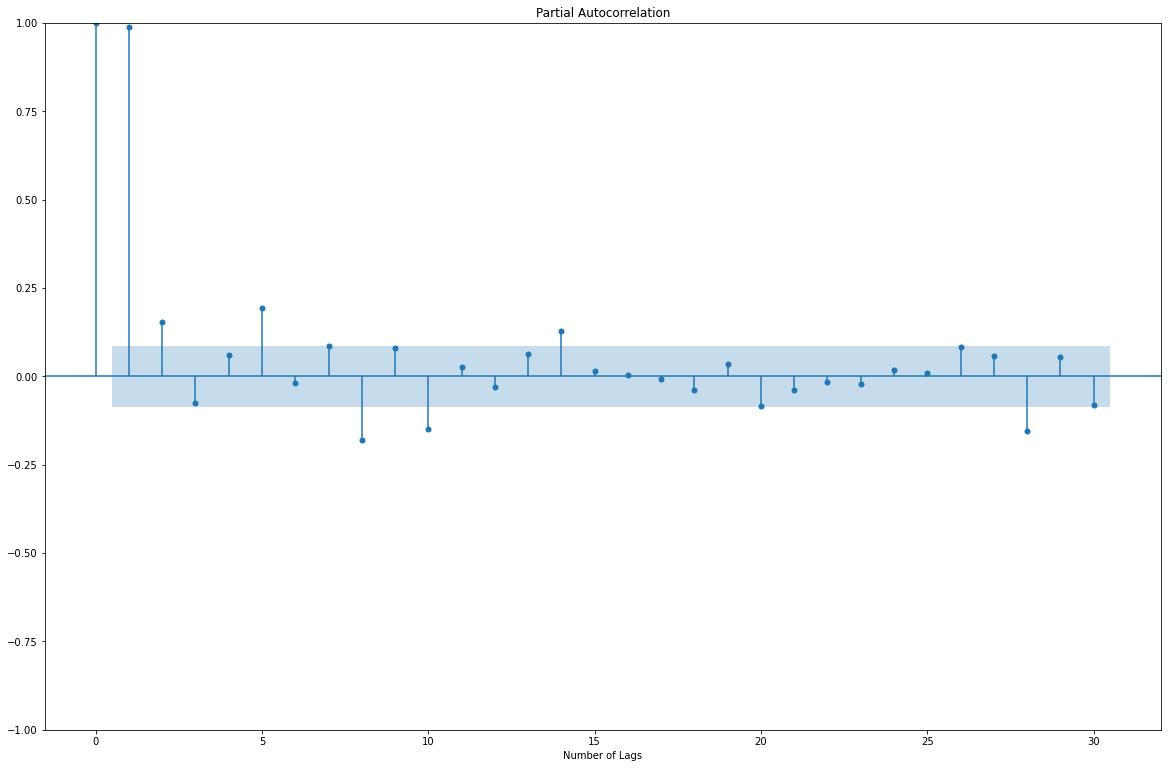

In [85]:
# AT&T PACF
pafc_T = sm.graphics.tsa.plot_pacf(stock_prices['T'], lags = 30)
plt.xlabel('Number of Lags')                                   
plt.show()

For AT&T there are about 8 significant terms that could be used in an AR model

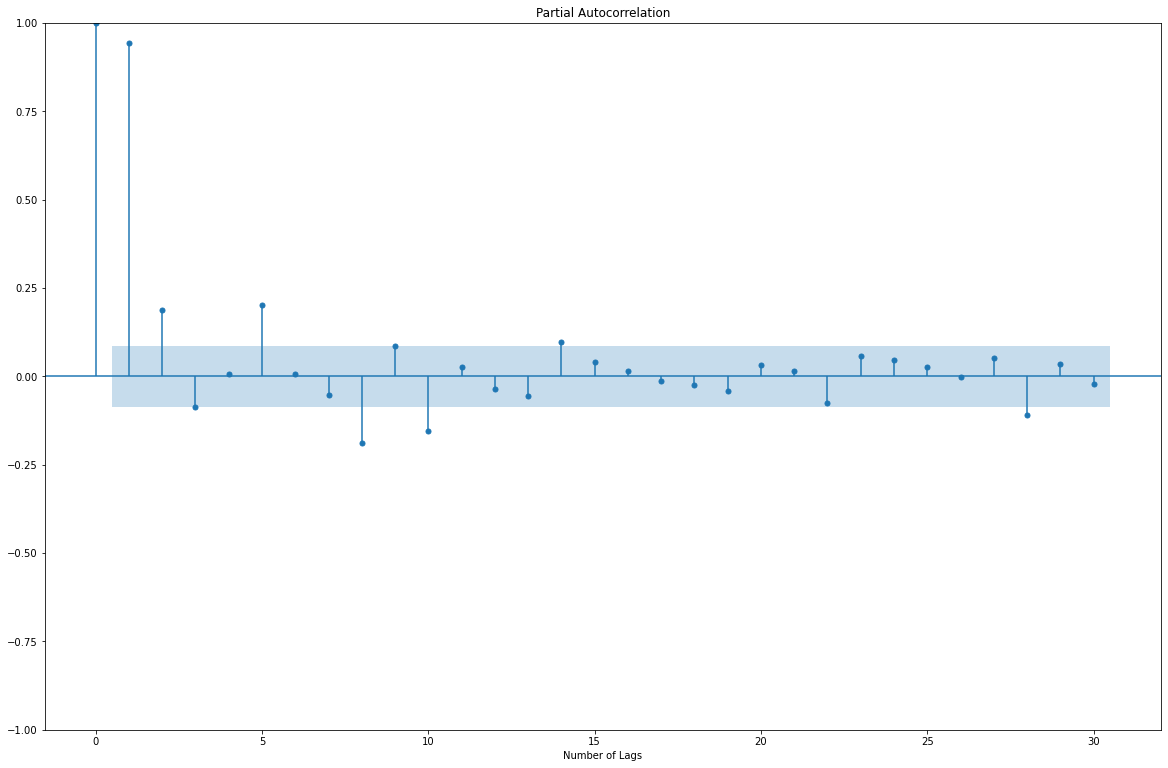

In [86]:
# V PACF 
pafc_V = sm.graphics.tsa.plot_pacf(stock_prices['VZ'], lags = 30)
plt.xlabel('Number of Lags')
plt.show()

For VZ there are about 7 significant terms that could be used in an AR model

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [91]:
vz_adf = adfuller(stock_prices['VZ'])
print('ADF Statistic: %f' % vz_adf[0])
print('p-value: %f' % vz_adf[1])
print('Critical Values:')
for key, value in vz_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.114514
p-value: 0.025498
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


The more negative the test statistics value, more likely we reject null and have stationary data.

In this case we can reject the null with a significance level of less than 5% . Data us stationary

In [90]:
t_adf = adfuller(stock_prices['T'])
print('ADF Statistic: %f' % t_adf[0])
print('p-value: %f' % t_adf[1])
print('Critical Values:')
for key, value in t_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.185624
p-value: 0.679749
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


Fail to reject the null. Data is non-stationary

###### Time to difference the data

In [95]:
diff_T = stock_prices['T'].diff().dropna()

In [97]:
diff_VZ = stock_prices['VZ'].diff().dropna()

In [98]:
diff_T_adf = adfuller(diff_T)

print('ADF Statistic: %f' % diff_T_adf[0])
print('p-value: %f' % diff_T_adf[1])
print('Critical Values:')
for key, value in diff_T_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.629084
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


In [99]:
dfii_VZ_adf = adfuller(diff_VZ)
print('ADF Statistic: %f' % dfii_VZ_adf[0])
print('p-value: %f' % dfii_VZ_adf[1])
print('Critical Values:')
for key, value in dfii_VZ_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.520162
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


###### Both are clearly stationary now.

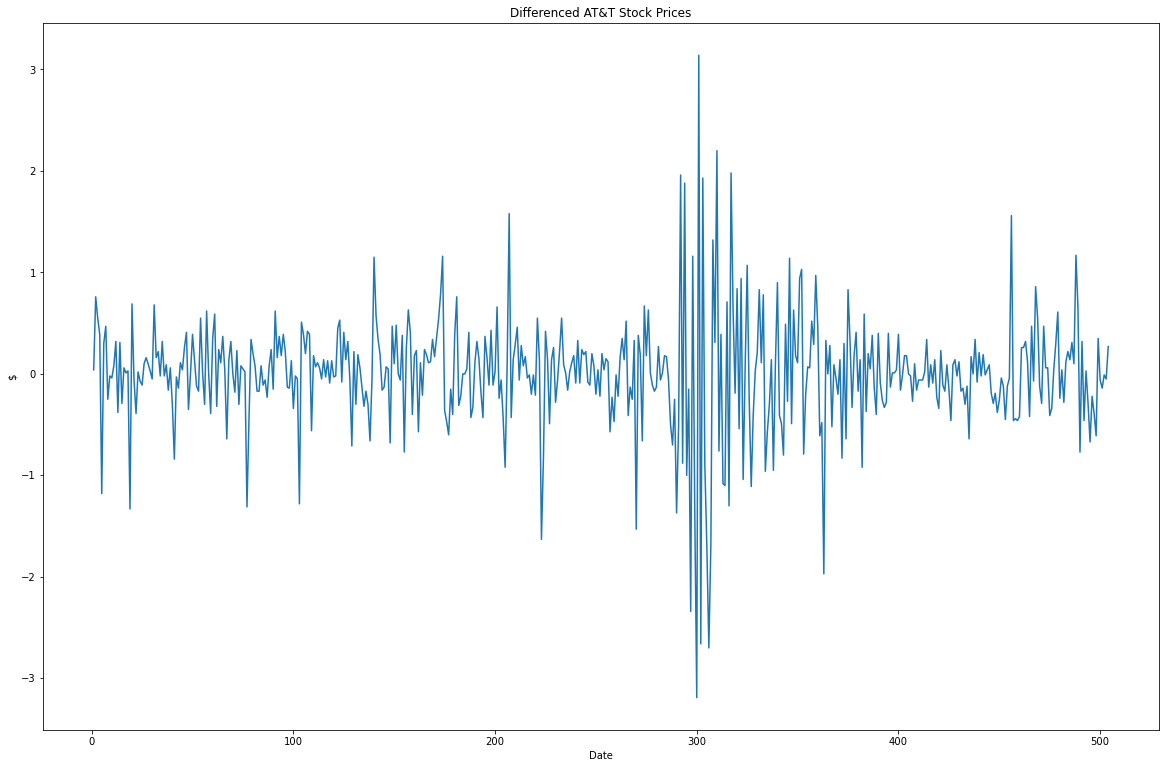

In [114]:
diff_T.plot()
plt.title('Differenced AT&T Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

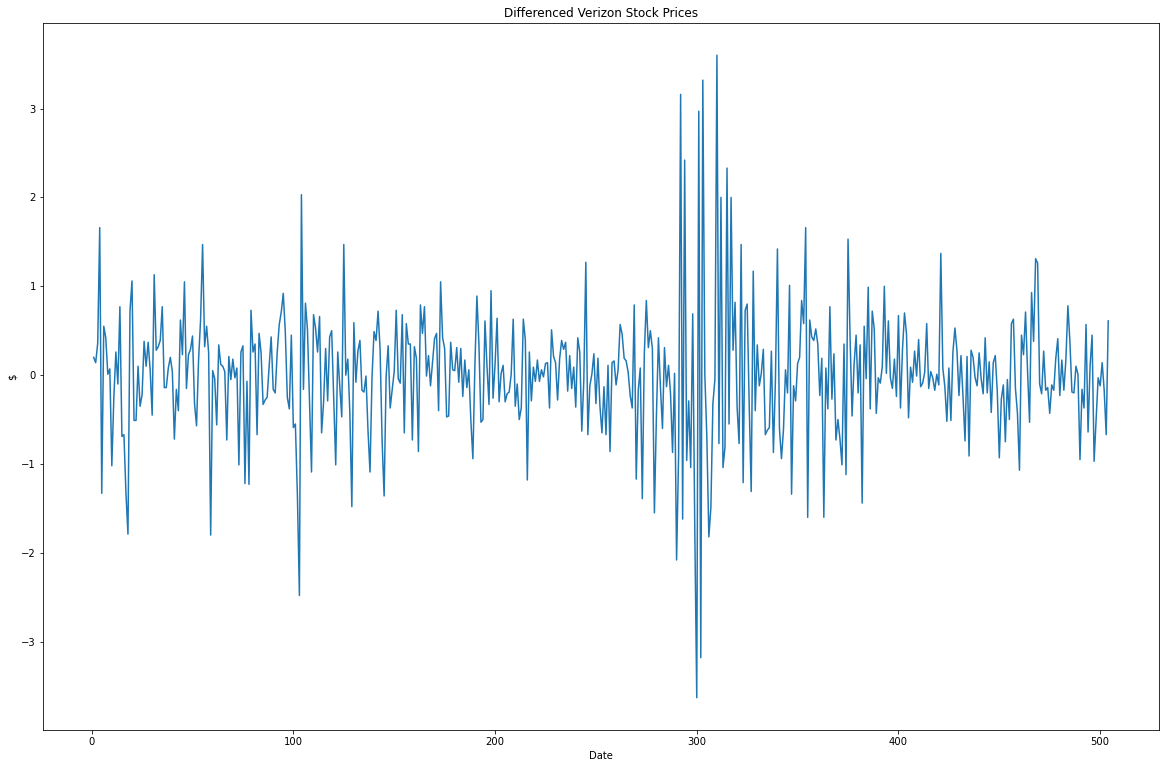

In [101]:
diff_VZ.plot()
plt.title('Differenced Verizon Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

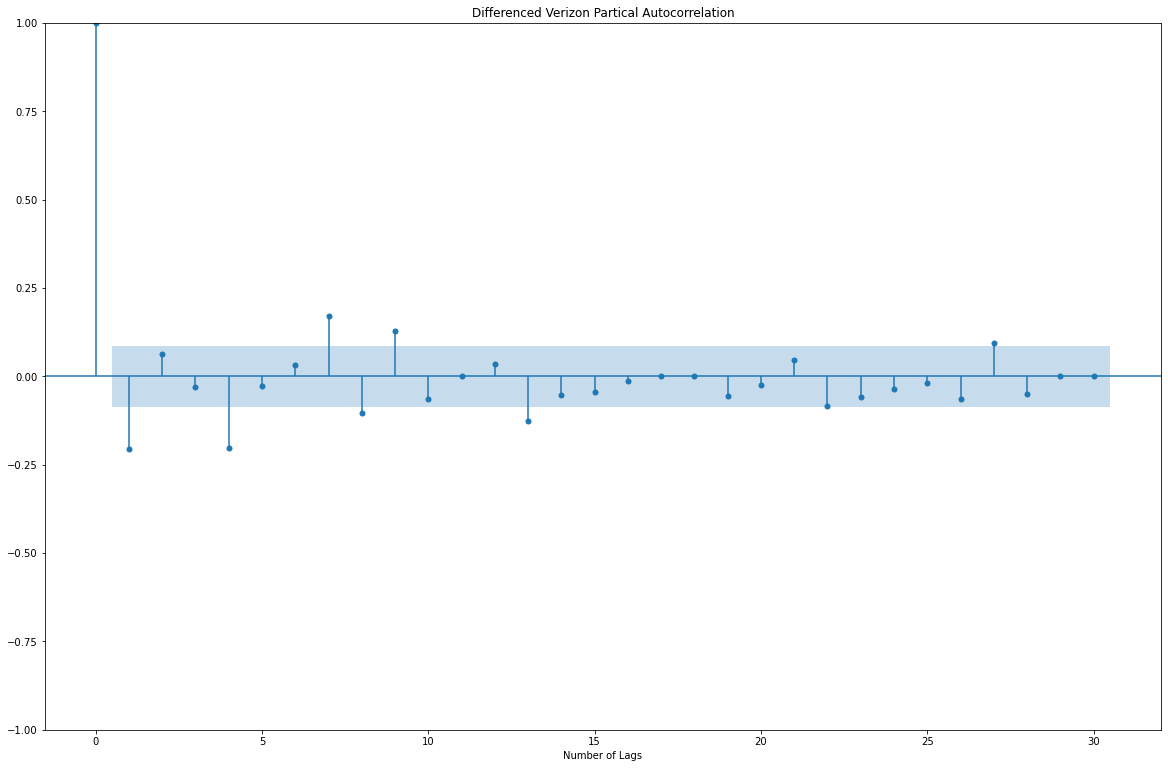

In [110]:
diff_pafc_V = sm.graphics.tsa.plot_pacf(diff_VZ, lags = 30)
plt.title('Differenced Verizon Partical Autocorrelation')
plt.xlabel('Number of Lags')
plt.show()

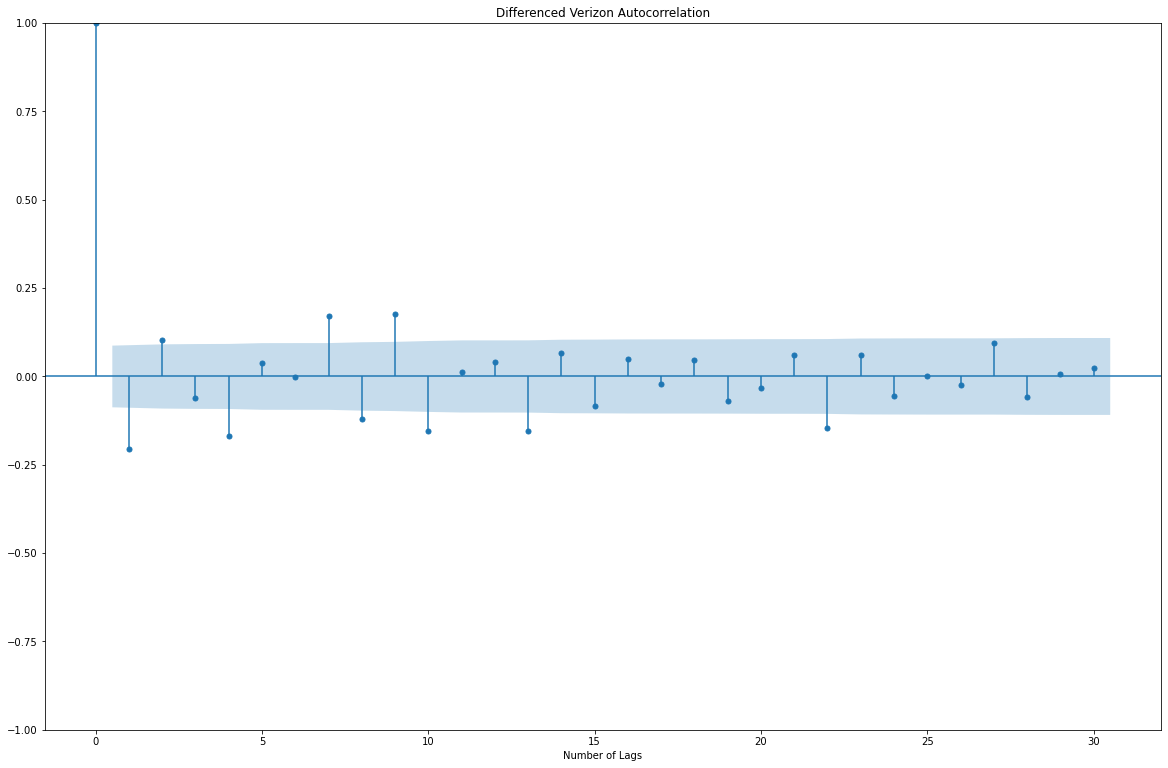

In [111]:
diff_pafc_V = sm.graphics.tsa.plot_acf(diff_VZ, lags = 30)
plt.title('Differenced Verizon Autocorrelation')
plt.xlabel('Number of Lags')
plt.show()

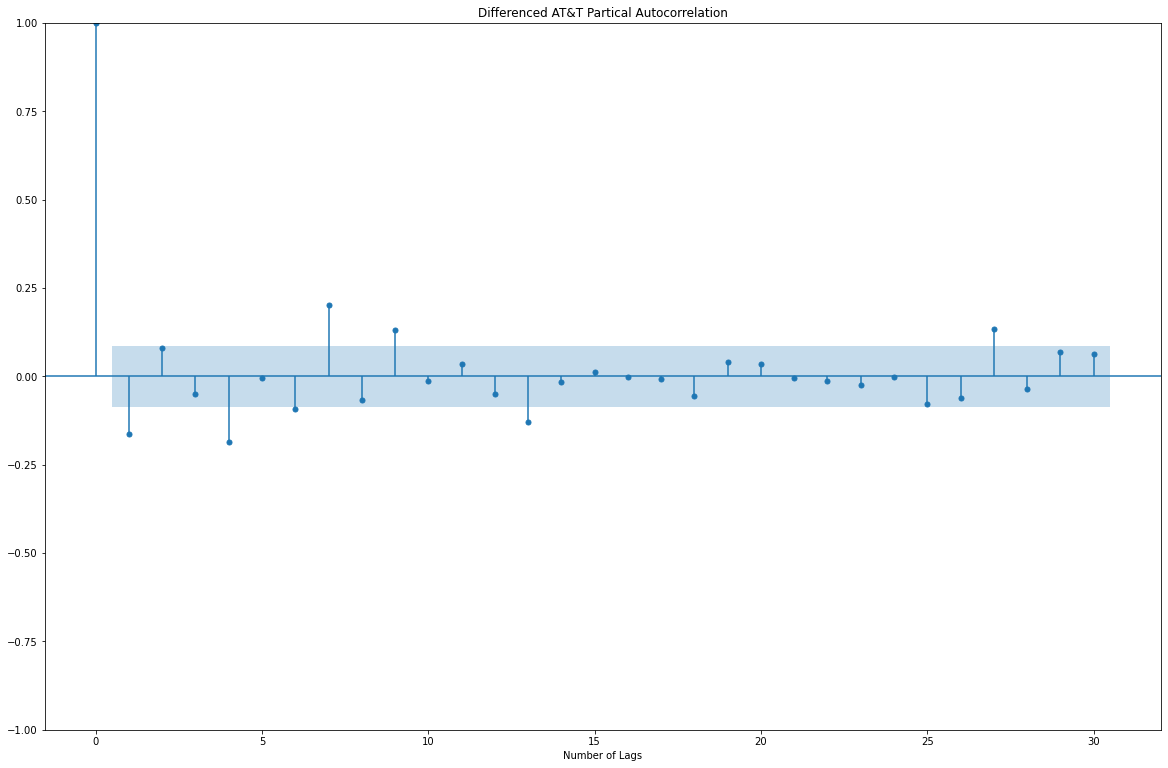

In [115]:
diff_pafc_T = sm.graphics.tsa.plot_pacf(diff_T, lags = 30)
plt.title('Differenced AT&T Partical Autocorrelation')
plt.xlabel('Number of Lags')
plt.show()

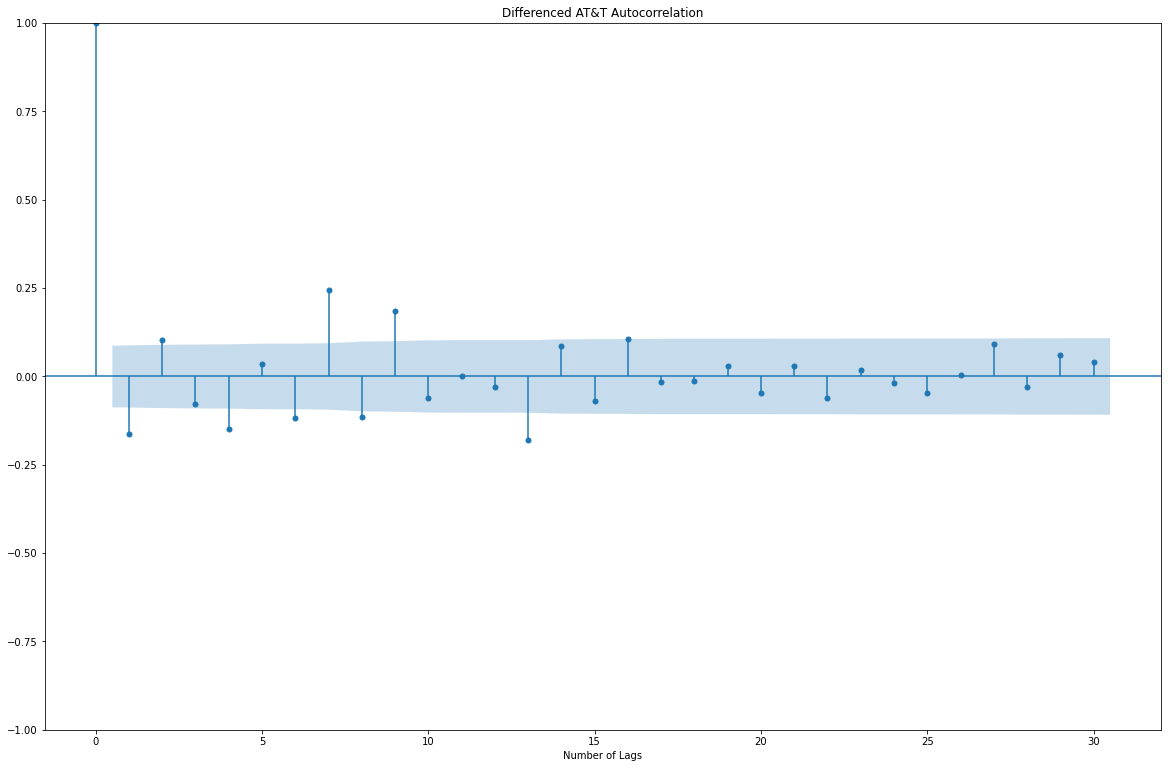

In [112]:
diff_pafc_T = sm.graphics.tsa.plot_acf(diff_T, lags = 30)
plt.title('Differenced AT&T Autocorrelation')
plt.xlabel('Number of Lags')
plt.show()